In [1]:
%load_ext autoreload
%autoreload 2
# Importing
import numpy as np
import numba
from scipy import optimize
from IPython.display import display
import matplotlib.pyplot as plt
import pandas as pd
import sequence_jacobian as ssj
import graphviz
from sequence_jacobian import drawdag

from model_functions import *

In [3]:
## creating the model
household_block = household_decision.add_hetinputs([set_wages, make_grids, set_transfers])
household_block = household_block.add_hetoutputs([get_mpc_transfers, intratemporal_consumption])
blocks_ss = [household_block, firm, taylor_rule_ss, nkwpc_ss, nkpc_ss, mkt_clearing]
hank_ss = ssj.create_model(blocks_ss, name="Pieroni HANK SS")

print(f'Household block inputs: {household_block.inputs}')
print(f'Internals: {household_block.internals}')
print(f'Outputs: {household_block.outputs}')
print(f'Model inputs: {hank_ss.inputs}')
print(f'Model outputs: {hank_ss.outputs}')

Household block inputs: ['r', 'beta', 'gamma_c', 'N', 'ce_min', 'alpha_c', 'sigma_c', 'p_e', 'p_g', 'p_index', 'w', 'rho_z', 'sd_z', 'n_z', 'amin', 'amax', 'n_a', 'profit', 'tax_total']
Internals: ['D', 'Dbeg', 'Pi_trans', 'Vprime_a', 'a', 'c', 'inc', 'nz', 'mpc', 'ce', 'cg', 'wz', 'z_grid', 'pi_stationary', 'a_grid', 'check_sum_productivity', 'transfers', 'div', 'tax']
Outputs: ['A', 'C', 'INC', 'NZ', 'MPC', 'CE', 'CG']
Model inputs: ['r', 'beta', 'gamma_c', 'ce_min', 'alpha_c', 'sigma_c', 'p_e', 'p_index', 'w', 'rho_z', 'sd_z', 'n_z', 'amin', 'amax', 'n_a', 'tax_total', 'theta_p', 'Y', 'phi_inf', 'theta_w', 'nu_n', 'B', 'E_s']
Model outputs: ['A', 'C', 'INC', 'NZ', 'MPC', 'CE', 'CG', 'mc', 'E_f', 'N', 'profit', 'p_g', 'i', 'r_ss', 'inf_w', 'target_w', 'inf_p', 'asset_mkt', 'energy_mkt', 'goods_mkt']


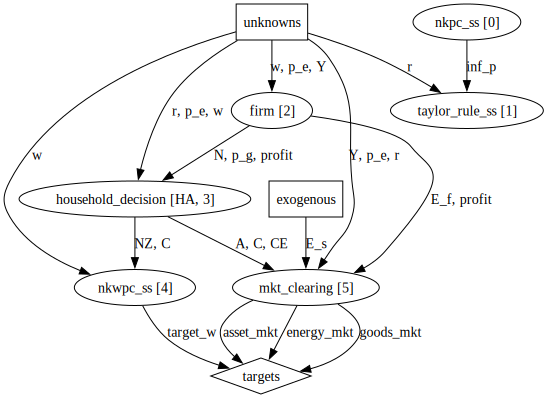

In [28]:
unknowns = ['r', 'w', 'p_e', 'Y']
targets = ['asset_mkt', 'target_w', 'energy_mkt', 'goods_mkt']
inputs = ['E_s']

drawdag(hank_ss, inputs, unknowns, targets, save=True, savepath="figures/pieroni_hank_ss_dag")

In [7]:
best_calibration = {
'gamma_c': 0.5,
'sigma_c': 0.1,
'alpha_c': 0.04,
'nu_n': 0.5, #0.5
'theta_p': 10.0,
'theta_w': 10.0,
'phi_inf' : 1.25,
'p_index': 1.0,
'tax_total': 0.0,
'n_z': 7,
'rho_z': 0.9,
'sd_z': 0.4,
'n_a': 150,
'amin': 0,
'amax': 100,
'beta': 0.995,
'B': 5.,#5
'E_s': 0.124, # 'E_s': 0.124,
'ce_min': 0.04, #0.06
}


In [8]:
calibration_ss_test = {
'gamma_c': 1,#0.5
'sigma_c': 0.1,
'alpha_c': 0.04,
'nu_n': 1, #0.5
'theta_p': 10.0,
'theta_w': 10.0,
'phi_inf' : 1.25,
'p_index': 1.0,
'tax_total': 0.0,
'n_z': 7,
'rho_z': 0.9,
'sd_z': 0.4,
'n_a': 200,
'amin': 0,
'amax': 150,
'beta': 0.995,
'B': 5.,#5
'E_s': 0.124, # 'E_s': 0.124,
'ce_min': 0.04, #0.06
}

unknowns_ss = {'r': 0.002, 'p_e': 0.1, 'w': 0.8, 'Y':1.2}

# equations that clear with the optimal value of unknown variables
targets_ss = {'asset_mkt':0., 'energy_mkt':0., 'target_w':0., 'goods_mkt':0}

In [9]:
## solve steady state with this calibration (here is where errors appear if they do)
ss_values = hank_ss.solve_steady_state(calibration_ss_test, unknowns_ss, targets_ss,
    options={'verbose': True, 'ttol': 1e-10},
    solver_kwargs={'maxcount': 5000})

In [10]:
## checking that the targets are 0 (aka markets clear)
print(f"Asset market clearing: {ss_values['asset_mkt']}")
print(f"energy market clearing: {ss_values['energy_mkt']: 0.2e}")
print(f"wage target: {ss_values['target_w']: 0.2e}")
print(f"goods market: {ss_values['goods_mkt']: 0.2e}")

Asset market clearing: -6.306066779870889e-13
energy market clearing:  5.00e-16
wage target: -3.22e-15
goods market:  2.44e-15


In [11]:
## checking end values
print(f"wage: {ss_values['w']}")
print(f"rate: {ss_values['r']}")
print(f"price energy: {ss_values['p_e']}") # Pieroni finds something close to P_e = 2 but idk if i should find that or not (idk if our models are too different)
print(f"labour: {ss_values['N']}")
print(f"energy firms: {ss_values['E_f']}")
print(f"Y: {ss_values['Y']}")

wage: 0.9910311065166308
rate: 0.0002333856922805986
price energy: 1.2175466474397574
labour: 1.0022220571621479
energy firms: 0.04090843662102234
Y: 1.0430411741704848


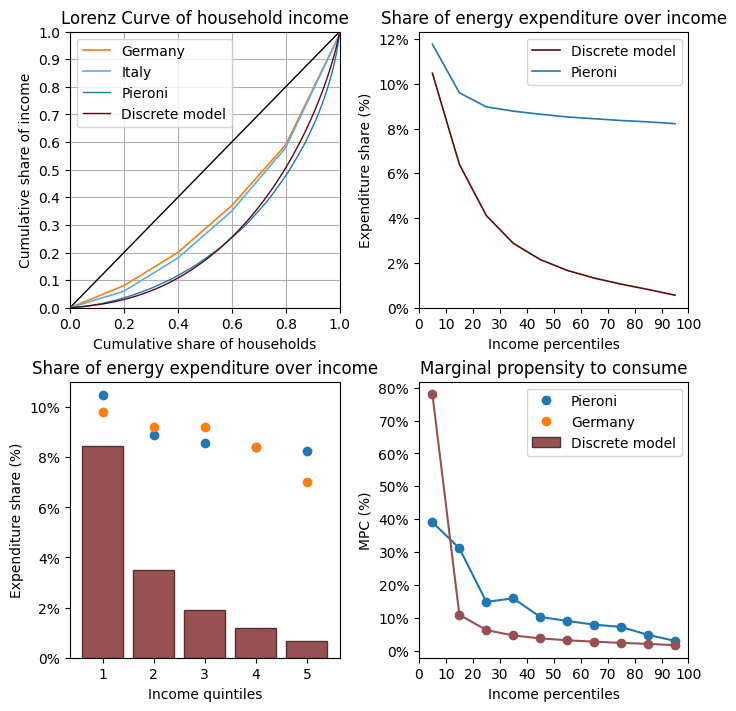

In [12]:
## analyse the fit of the results to the ideal targets (statistics) of Pieroni and what Pieroni gets himself
from ss_analysis_functions import *
summary_statistics = return_statistics(ss_values) # targets are specific values or ranges 
# if "distribution has negative value" error appears i think thats not an acceptable calibration, thats not something we want
# (i am unsure of whether average_mpc and int rate, the last two, are good references so i focus on the first four)
fig= draw_figures(ss_values)

In [13]:
summary_statistics

{'average_wealth_to_income_share': {'Model': np.float64(4.937654495836828),
  'Pieroni': 4.4178,
  'Target': 4.2},
 'total_energy_share_output': {'Model': np.float64(0.036186439236830396),
  'Pieroni': 0.0403,
  'Target': 0.04},
 'average_energy_expenditure_share': {'Model': np.float64(0.07811012662705129),
  'Pieroni': 0.0892,
  'Target': '[0.06:0.12]'},
 'gini': {'Model': 0.4669034738542448, 'Pieroni': 0.4812, 'Target': 0.35},
 'average_mpc': {'Model': np.float64(0.11516196604908738),
  'Pieroni': 0.1069,
  'Target': '[0.15:0.25]'},
 'annualized_percent_rate': {'Model': np.float64(0.09335427691223945),
  'Pieroni': 2.9139}}

## Dynamic model

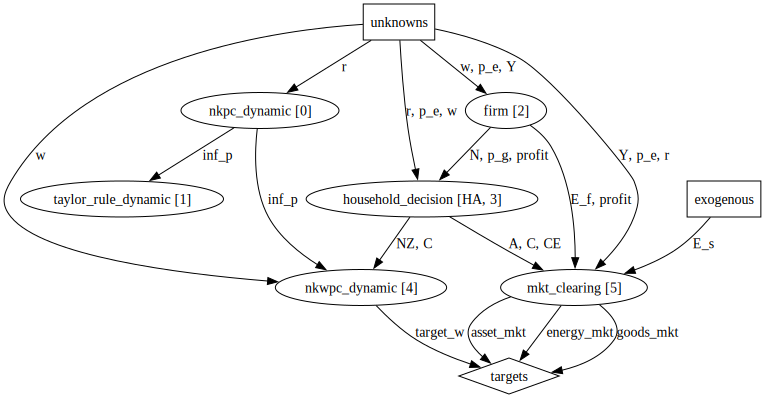

<SimpleBlock 'nkpc_dynamic'>
<SimpleBlock 'taylor_rule_dynamic'>
<SimpleBlock 'firm'>
<HetBlock 'household_decision' with hetinput 'make_grids_set_wages' and with hetoutput `intratemporal_consumption_get_mpc_transfers'>
<SimpleBlock 'nkwpc_dynamic'>
<SimpleBlock 'mkt_clearing'>


In [ ]:
household_block = household_decision.add_hetinputs([set_wages, make_grids, set_transfers])
household_block = household_block.add_hetoutputs([get_mpc_transfers, intratemporal_consumption])
blocks = [household_block, firm, taylor_rule_dynamic, nkpc_dynamic, nkwpc_dynamic, mkt_clearing]
hank = ssj.create_model(blocks, name="Pieroni HANK Dynamic")

unknowns = ['r', 'w', 'Y', 'p_e']
targets = ['asset_mkt', 'target_w', 'energy_mkt', 'goods_mkt']
inputs = ['E_s']

drawdag(hank, inputs, unknowns, targets, save=True, savepath="figures/pieroni_hank_dynamic_dag")

print(*hank.blocks, sep='\n')

ss = hank.steady_state(ss_values)

for k in ss_values.keys():
    np.all(np.isclose(ss[k], ss_values[k]))

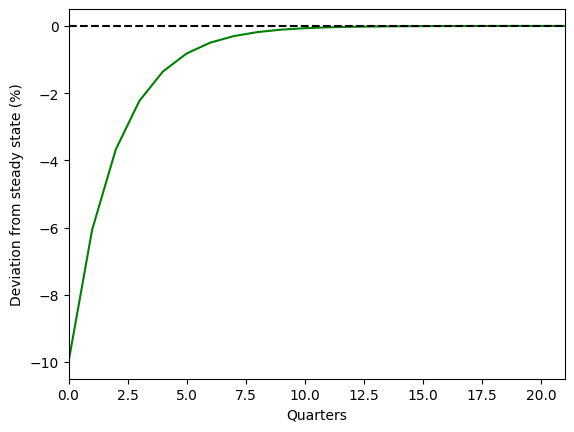

In [15]:
# Figure: Energy supply shock
T = 31
zero_line = np.zeros_like(np.arange(T))
E_s_shock = - 0.1 * np.exp(-0.5 * np.arange(T))
E_s_path = ss['E_s'] * (1 - E_s_shock)
plt.plot(E_s_shock*100, color='green')
plt.plot(zero_line, "k--")
plt.xlim(0, 21)
plt.xlabel("Quarters")
plt.ylabel("Deviation from steady state (%)")
# plt.title("Energy supply shock")
plt.show()

### solve_jacobian function

<JacobianDict outputs=['r', 'w', 'Y', 'p_e', 'A', 'C', 'INC', 'NZ', 'MPC', 'CE', 'CG', 'mc', 'E_f', 'N', 'profit', 'p_g', 'i', 'inf_p', 'inf_w', 'target_w', 'asset_mkt', 'energy_mkt', 'goods_mkt'], inputs=['E_s']>


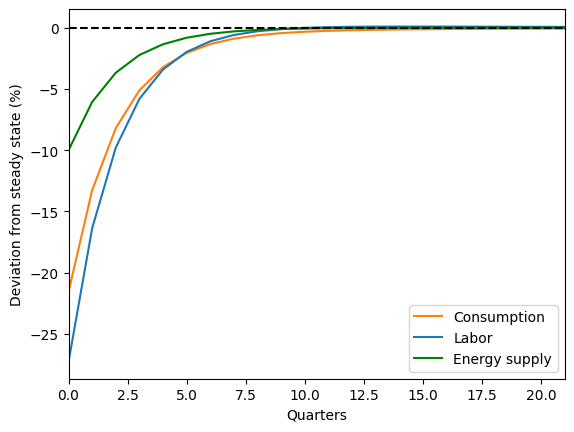

In [16]:
# compute general equilibrium jacobians
G = hank.solve_jacobian(ss, unknowns, targets, inputs, T=T)
print(G)

# Figure: Aggregates IRF
change_C = G['C']['E_s'] @ E_s_shock
change_L = G['NZ']['E_s'] @ E_s_shock
change_r = G['r']['E_s'] @ E_s_shock
change_inf = G['inf_p']['E_s'] @ E_s_shock
plt.plot(100 * change_C, label='Consumption', color="#ff7f0e")
plt.plot(100 * change_L, label='Labor', color= "#1f77b4")
plt.plot(100 * E_s_shock, label='Energy supply', color='green')
plt.plot(zero_line, "k--")
# plt.title('Response of aggregates to an energy supply shock using solve_jacobian', fontsize=10)
# plt.title('Response of Consumption and Labor (discrete time)', fontsize=10)
plt.xlim(0, 21)
plt.xlabel("Quarters")
plt.ylabel("Deviation from steady state (%)")
plt.legend()
plt.show()

### Solve the linear dynamics

In [17]:
E_s_shock_path = {"E_s": E_s_shock}

shock_lin = hank.solve_impulse_linear(ss, unknowns, targets, E_s_shock_path)

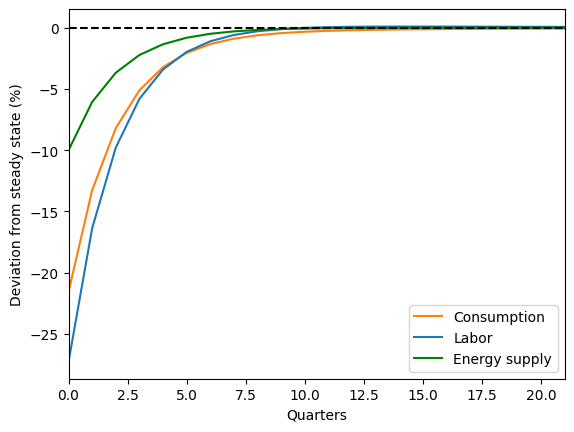

In [18]:
dC_lin = 100 * shock_lin['C']
dA_lin = 100 * shock_lin['A']
dinc_lin = 100 * shock_lin['INC']
dL_lin = 100 * shock_lin['NZ']
dEs_lin = 100 * shock_lin['E_s']
# dY_lin = 100 * shock_lin['Y'] # no Y in the linear shock! maybe we need
plt.plot(dC_lin, label='Consumption', linestyle='-', color =  "#ff7f0e") # same as INC
# plt.plot(dA_lin[:21], label='A', linestyle='-') # no change since A = B
plt.plot(dL_lin, label='Labor', linestyle='-', color =  "#1f77b4")
# plt.plot(dinc_lin[:21], label='income', linestyle='-') # same as C
plt.plot(dEs_lin, label='Energy supply', linestyle='-', color='green')
plt.plot(zero_line, "k--")
# plt.title('Response of aggregates to an energy supply shock using solve_impulse_linear', fontsize=10)
plt.xlim(0, 21)
plt.xlabel("Quarters")
plt.ylabel("Deviation from steady state (%)")
plt.legend()
plt.show()

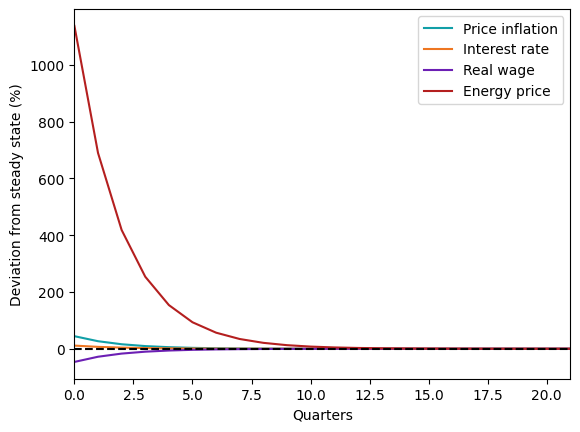

In [19]:
dinf_lin = 100 * shock_lin['inf_p']
dpe_lin = 100 * shock_lin['p_e']
dpg_lin = 100 * shock_lin['p_g']
dr_lin = 100 * shock_lin['r']
dw_lin = 100 * shock_lin['w']
zero_line = np.zeros_like(dL_lin)
plt.plot(dinf_lin, label='Price inflation', linestyle='-', color="#119FA7")
plt.plot(dr_lin, label='Interest rate', linestyle='-', color="#EE7621")
plt.plot(dw_lin, label='Real wage', linestyle='-', color="#6c1fb4")
plt.plot(dpe_lin, label='Energy price', linestyle='-', color="#b41f1f")
plt.plot(zero_line, "k--")
# plt.title("Response of prices to 10% E_s shock")
plt.xlim(0, 21)
plt.xlabel("Quarters")
plt.ylabel("Deviation from steady state (%)")
plt.legend()
plt.show()

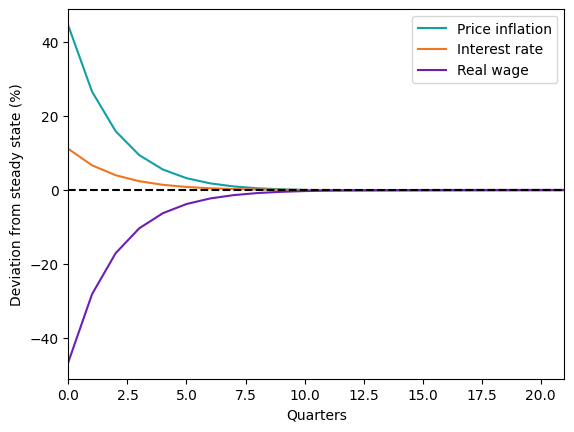

In [20]:
dinf_lin = 100 * shock_lin['inf_p']
dpe_lin = 100 * shock_lin['p_e']
dpg_lin = 100 * shock_lin['p_g']
dr_lin = 100 * shock_lin['r']
dw_lin = 100 * shock_lin['w']
zero_line = np.zeros_like(dL_lin)
plt.plot(dinf_lin, label='Price inflation', linestyle='-', color="#119FA7")
plt.plot(dr_lin, label='Interest rate', linestyle='-', color="#EE7621")
plt.plot(dw_lin, label='Real wage', linestyle='-', color="#6c1fb4")
# plt.plot(dw_lin, label='pg', linestyle='-') # follows the same trajectory as wages
# plt.plot(dpe_lin, label='Energy price', linestyle='-', color="#b41f1f")
plt.plot(zero_line, "k--")
# plt.title("Prices' response to 10% E_s shock (no )")
# plt.title(r'Response of inflation, interest rate and wage to 10% E_s shock')
plt.xlim(0, 21)
plt.xlabel('Quarters')
plt.ylabel('Deviation from steady state (%)')
plt.legend()
plt.show()

# r is stable, it is = r_ss the whole time, and thus causes the behaviour of inf. 
# Might also explain the behaviour of A, although it is weird that  inc changes

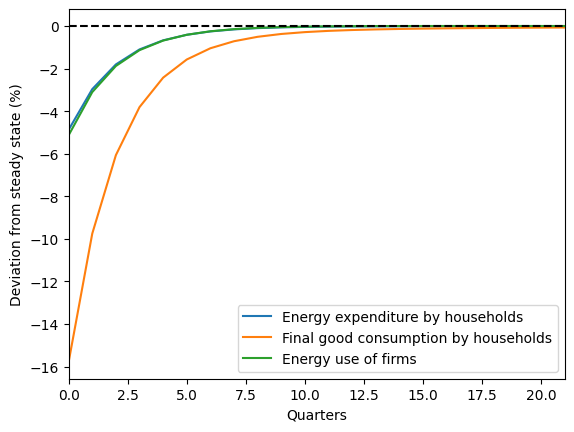

In [21]:
dCE_lin = 100 * shock_lin['CE']
dCG_lin = 100 * shock_lin['CG']
dEf_lin = 100 * shock_lin['E_f']
zero_line = np.zeros_like(dL_lin)
plt.plot(dCE_lin, label='Energy expenditure by households', linestyle='-')
plt.plot(dCG_lin, label='Final good consumption by households', linestyle='-')
plt.plot(dEf_lin, label='Energy use of firms', linestyle='-')
# plt.plot(dpe_lin, label='Energy price', linestyle='-', color="#b41f1f")
plt.plot(zero_line, "k--")
# plt.title("Prices' response to 10% E_s shock (no )")
# plt.title(r'Response of inflation, interest rate and wage to 10% E_s shock')
plt.xlim(0, 21)
plt.xlabel('Quarters')
plt.ylabel('Deviation from steady state (%)')
plt.legend()
plt.show()

### Plotting Pieroni's results

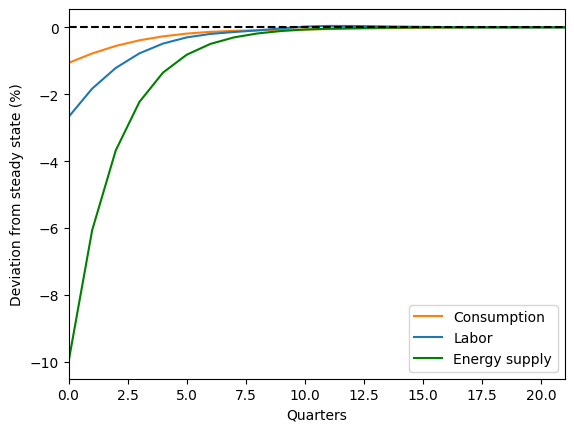

In [27]:
# reproducing Pieroni's results
mat = pd.read_csv("pieroni_data/irf_matlab.csv", header=None, names=["Pieroni_C","Pieroni_L","Pieroni_pi","Pieroni_r","Pieroni_w","Pieroni_pe"])

# Figure: aggregates
plt.plot(mat.Pieroni_C, label="Consumption", linestyle='-', color =  "#ff7f0e")
plt.plot(mat.Pieroni_L, label="Labor", linestyle='-', color =  "#1f77b4")
plt.plot(dEs_lin, label='Energy supply', linestyle='-', color='green')
plt.plot(zero_line, "k--")
plt.xlim(0, 21)
plt.xlabel('Quarters')
plt.ylabel('Deviation from steady state (%)')
plt.legend()
plt.show()

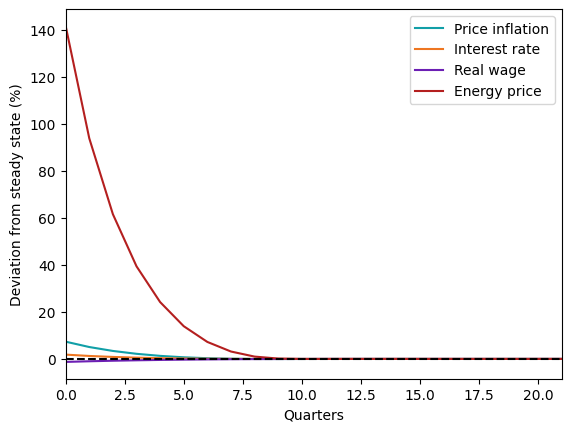

In [23]:
plt.plot(mat.Pieroni_pi, label='Price inflation', linestyle='-', color="#119FA7")
plt.plot(mat.Pieroni_r, label='Interest rate', linestyle='-', color="#EE7621")
plt.plot(mat.Pieroni_w, label='Real wage', linestyle='-', color="#6c1fb4")
plt.plot(mat.Pieroni_pe, label='Energy price', linestyle='-', color="#b41f1f")
plt.plot(zero_line, "k--")
plt.xlim(0, 21)
plt.xlabel('Quarters')
plt.ylabel('Deviation from steady state (%)')
plt.legend()
plt.show()

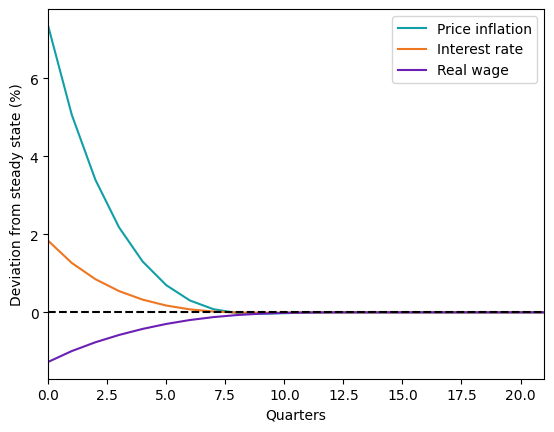

In [24]:
plt.plot(mat.Pieroni_pi, label='Price inflation', linestyle='-', color="#119FA7")
plt.plot(mat.Pieroni_r, label='Interest rate', linestyle='-', color="#EE7621")
plt.plot(mat.Pieroni_w, label='Real wage', linestyle='-', color="#6c1fb4")
# plt.plot(mat.Pieroni_pe, label='Energy price', linestyle='-', color="#b41f1f")
plt.plot(zero_line, "k--")
plt.xlim(0, 21)
plt.xlabel('Quarters')
plt.ylabel('Deviation from steady state (%)')
plt.legend()
plt.show()

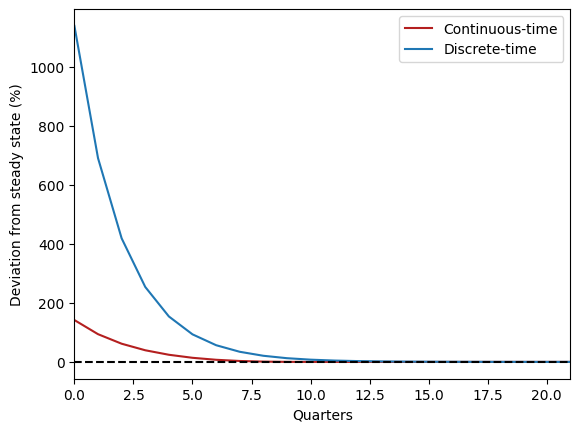

In [25]:
plt.plot(mat.Pieroni_pe, label='Continuous-time', linestyle='-', color="#b41f1f")
plt.plot(dpe_lin, label='Discrete-time', linestyle='-')
plt.plot(zero_line, "k--")
plt.xlim(0, 21)
plt.xlabel('Quarters')
plt.ylabel('Deviation from steady state (%)')
plt.legend()
plt.show()

### Non-linear response

In [26]:
shock_nonlin = hank.solve_impulse_nonlinear(ss, unknowns, targets, E_s_shock_path) # does not work: No convergence after 30 backward iterations!

Solving Pieroni HANK Dynamic for ['r', 'w', 'Y', 'p_e'] to hit ['asset_mkt', 'target_w', 'energy_mkt', 'goods_mkt']
On iteration 0
   max error for asset_mkt is 1.99E-07
   max error for target_w is 5.67E-09
   max error for energy_mkt is 1.00E-01
   max error for goods_mkt is 6.28E-09
On iteration 1
   max error for asset_mkt is 1.82E-01
   max error for target_w is 5.59E-02
   max error for energy_mkt is 6.57E-02
   max error for goods_mkt is 1.63E-01
On iteration 2
   max error for asset_mkt is 3.15E-01
   max error for target_w is 8.20E-02
   max error for energy_mkt is 5.34E-02
   max error for goods_mkt is 2.55E-01
On iteration 3
   max error for asset_mkt is 3.71E-01
   max error for target_w is 8.85E-02
   max error for energy_mkt is 4.40E-02
   max error for goods_mkt is 2.96E-01
On iteration 4
   max error for asset_mkt is NAN
   max error for target_w is NAN
   max error for energy_mkt is NAN
   max error for goods_mkt is NAN


/Users/artur/Documents/GitHub/Code_files/lib/python3.13/site-packages/sequence_jacobian/blocks/support/simple_displacement.py:432: RuntimeWarning: invalid value encountered in power


ValueError: array must not contain infs or NaNs